In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy import stats

In [2]:
#introducimos la base de datos
data = pd.read_csv('diamonds_data.csv')
#observando la base de datos
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
#Observemos la informacion de la base de datos para ver que todo esta en orden
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53930 entries, 0 to 53929
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53930 non-null  float64
 1   cut      53930 non-null  object 
 2   color    53930 non-null  object 
 3   clarity  53930 non-null  object 
 4   depth    53930 non-null  float64
 5   table    53930 non-null  float64
 6   price    53930 non-null  int64  
 7   x        53930 non-null  float64
 8   y        53930 non-null  float64
 9   z        53930 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


Las variables cut, color y clarity se tratan como objeto y son categoricas, haremos ese cambio y las demas estan correctamente definidas asi que se procede al modelo de las mismas, escogemos como variable respuesta al preciode los diamantes. Tomaremos una parte de la base para analisis y otra para es test del modelo.

Como la base de datos consta de 53 mil lineas, tomamos el 80% de la base para entrenamiento.

In [8]:
#Cambio a categorica
data['cut'] = data['cut'].astype('category')
data['color'] = data['color'].astype('category')
data['clarity'] = data['clarity'].astype('category')

In [4]:
53929*0.8

43143.200000000004

In [9]:
train = data.iloc[0:43143,:]
test= data.iloc[43143:53929,:]

Veamos en un histograma el comportamiento de las variables categoricas.

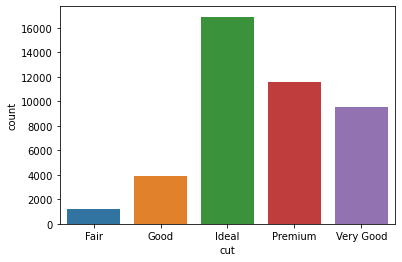

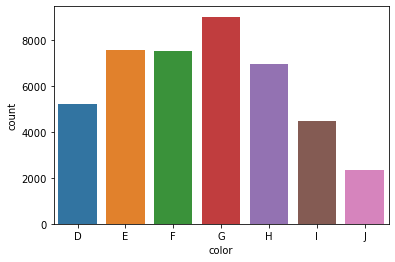

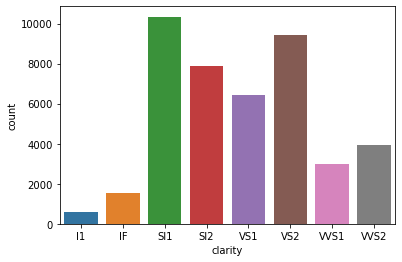

In [12]:
for i, col in enumerate(train[['cut', 'color', 'clarity']].columns):
    plt.figure(i)
    sns.countplot(x=col, data=train[['cut', 'color', 'clarity']])

Las variables categoricas tienen un buen comportamiento, pueden ser necesariris para describir el precio del diamante, así que seguro seranutilizadas en el modelo LASSO que usa variables categóricas para modelar.

# Modelo Lineal.
Veamos las variables numericas más correlacionadas con la variable respuesta por medio de una matriz de correlacion.

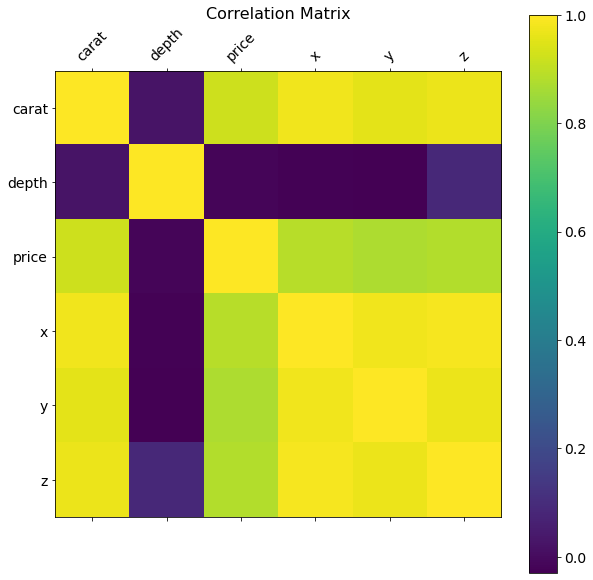

In [14]:
train_num = train[['carat', 'depth', 'price', 'x', 'y', 'z']]
#Graficamos la matriz de correlaciones
f = plt.figure(figsize=(10,10))
plt.matshow(train_num.corr(), fignum=f.number)
plt.xticks(range(train_num.shape[1]), train_num.columns, fontsize=14, rotation=45)
plt.yticks(range(train_num.shape[1]), train_num.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Como se puede observar las variables x,y,z estan bastante correlacionadas asi que solo se tomara una de ellas para hacer el modelo lineal. Por lo demas el precio no tiene ninguna correlacion con depth asi que no sirve como variable explicativa. Estas variables seran retiradas al ser seleccionadas por un criterio de correlacion.

In [16]:
newtrain_num = train[['carat', 'depth', 'price', 'x']]

In [24]:
#Quitamos de la base las variables que no tienen tanta correlacion con la variable respuesta
corMatrix = newtrain_num.corr()
corMatrix['price']
Resp_Corr=abs(corMatrix.iloc[:,2])
Resp_Opt=Resp_Corr.sort_values(ascending=False)
Explic=Resp_Opt.index[Resp_Opt>0.6]
Explic

Index(['price', 'carat', 'x'], dtype='object')

In [26]:
# Con base en la correlación, vamos a seleccionar las que tengan
# una > 0.6 con la variable respuesta.
train_selec = newtrain_num[Explic]

Ya que tenemos todo list para modelar, importamos el modelo lineal y hacemos el entrenamiento.

In [38]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(normalize=False)
linear_model.fit(train_selec[['carat','x']],train_selec['price'])
#imprimimos los coeficientes
linear_model.coef_

array([9495.42355689, -759.17296881])

Ahora usamos la base de test para medir la eficacia de nuestro modelo.

In [39]:
test_num = test[['carat', 'x']]

In [40]:
y_predict = linear_model.predict(test_num)

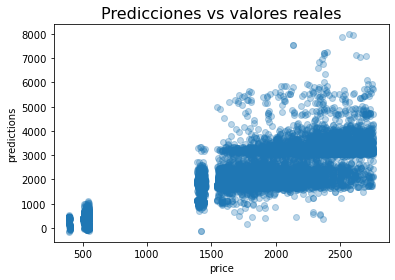

In [42]:
plt.scatter(test['price'],y_predict, alpha = 0.3)
plt.xlabel('price')
plt.ylabel('predictions')
plt.title('Predicciones vs valores reales', fontsize=16)
plt.show()

Vemos que el modelo hace buenas predicciones de los valores, veamos el score del modelo.

In [44]:
linear_model.score(train_selec[['carat','x']],train_selec['price'] )

0.8502515155018063

Tiene un buen calificador. Pero haremos el modelo LASSO para no tener solo un modelo.
# LASSO

Haremos una matriz de 0 y 1 para poder usar las categorias como variabls explicativas, a estas se le conocerarn como dummies.

In [60]:
data2 = pd.read_csv('diamonds_data.csv')
dummies = []
for i in data2.columns:
    if (data2[i].dtype=='object'):
        dummies.append(i)
dummies

['cut', 'color', 'clarity']

In [61]:
status =  pd.get_dummies(data2[dummies],drop_first=True) ## one hot encoding on all variables
Xjoin = pd.concat([data2,status],axis=1)
Xjoin.drop(dummies,axis=1,inplace=True)
Xjoin.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [63]:
#Separamos en train y test nuevamente
train2 = Xjoin.iloc[0:43143,:]
test2 = Xjoin.iloc[43143:53929,:]

In [64]:
from sklearn.linear_model import Lasso 
lasso_model = Lasso(alpha=0.5,normalize=False, max_iter=1e6)
lasso_model.fit(train2.drop(columns = ['price']), train2['price'])
#imprimimos los coef
lasso_model.coef_

array([10832.66035118,   -63.73336673,   -32.75123733,  -792.47361486,
          14.07580287,   -70.82247774,   638.62681881,   930.97002018,
         825.65190524,   815.60915786,  -200.88996447,  -258.98257229,
        -493.1412031 , -1063.78832941, -1576.51930541, -2596.98770361,
        5596.38136797,  3814.74095896,  2758.50685189,  4832.51151466,
        4521.44279272,  5250.36929693,  5240.15589815])

In [67]:
y_lasso =lasso_model.predict(test2.drop(columns = ['price']))

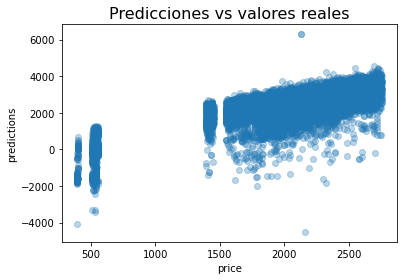

In [68]:
plt.scatter(test2['price'],y_lasso, alpha = 0.3)
plt.xlabel('price')
plt.ylabel('predictions')
plt.title('Predicciones vs valores reales', fontsize=16)
plt.show()

Por lo que se ve hace mejores predicciones que el modelo lineal. Por último veamos el score.

In [69]:
lasso_model.score(train2.drop(columns = ['price']), train2['price'])

0.9208652460766457

Como vemos tiene mucho mejor calificacion que el modelo lineal.

# Conclusion

Se recomienda usar el modelo lasso ya que tiene mejores predicciones e hizo uso de variables categorias que por lo visto tienen más correspondecia con el predio del diamante.